##### UnZip the dataset

In [ ]:
!wget https://github.com/nandakishormpai2001/manglish_lyrics_generator/raw/main/model/train_notebook/data.zip

--2021-05-24 17:28:53--  https://github.com/nandakishormpai2001/manglish_lyrics_generator/raw/main/model/train_notebook/data.zip
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/nandakishormpai2001/manglish_lyrics_generator/main/model/train_notebook/data.zip [following]
--2021-05-24 17:28:53--  https://raw.githubusercontent.com/nandakishormpai2001/manglish_lyrics_generator/main/model/train_notebook/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3540509 (3.4M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   3.38M  10.4MB/s    in 0.3s    

2021-05

In [ ]:
!unzip "data.zip"

Archive:  data.zip
   creating: data/
  inflating: data/dataset.csv        
  inflating: data/index_to_word.json  
  inflating: data/manglish_model.pth  
  inflating: data/missed_movies.txt  
  inflating: data/word_to_index.json  
  inflating: data/words.txt          
   creating: data/lyrics/
  inflating: data/lyrics/0.txt       
  inflating: data/lyrics/1.txt       
  inflating: data/lyrics/10.txt      
  inflating: data/lyrics/11.txt      
  inflating: data/lyrics/12.txt      
  inflating: data/lyrics/13.txt      
  inflating: data/lyrics/14.txt      
  inflating: data/lyrics/15.txt      
  inflating: data/lyrics/16.txt      
  inflating: data/lyrics/17.txt      
  inflating: data/lyrics/18.txt      
  inflating: data/lyrics/19.txt      
  inflating: data/lyrics/2.txt       
  inflating: data/lyrics/20.txt      
  inflating: data/lyrics/21.txt      
  inflating: data/lyrics/22.txt      
  inflating: data/lyrics/23.txt      
  inflating: data/lyrics/24.txt      
  inflating: data/lyr

##### Pip Install the required libraries

In [ ]:
!pip install -r requirements.txt

##### Import the libraries

In [ ]:
import torch
import pandas as pd
from collections import Counter
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader
import os
import random
import pickle
import matplotlib.pyplot as plt

###### Define the Model Class

In [ ]:
class Model(nn.Module):
    # Set hidden layer parameters
    def __init__(self, dataset):
        super(Model, self).__init__()
        self.lstm_size = 128
        self.embedding_dim = 128
        self.num_layers = 2

        n_vocab = len(dataset.uniq_words)
        
        # Embedding layer converts word indexes to word vectors.
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )
        # Define the LSTM, the number of expected features and that of layers
        self.lstm = nn.LSTM(
            input_size=self.lstm_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=0.2,
        )
        # Define the Fully Connected layer
        self.fc = nn.Linear(self.lstm_size, n_vocab)

    # Defines the network structure, here consisting of the embedding layer, LSTM layer and the fully connected layer. 
    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)
        return logits, state

    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.lstm_size),
                torch.zeros(self.num_layers, sequence_length, self.lstm_size))

##### Define the Dataset Class

In [ ]:
class Dataset():
    def __init__(self):
        self.words = self.load_words()
        text_file = open("data/words.txt", "w")
        text_file.write(" ".join(self.words))
        text_file.close()
        self.uniq_words = self.get_uniq_words()

        # index_to_word and word_to_index converts words to number indexes and visa versa.
        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}
        with open('data/index_to_word.json', 'wb') as iw:
            pickle.dump(self.index_to_word, iw)
        with open('data/word_to_index.json', 'wb') as wi:
            pickle.dump(self.word_to_index, wi)    
        

        self.words_indexes = [self.word_to_index[w] for w in self.words]

        self.sequence_length=100

    
    def load_words(self):

        """ Returns words [list] - list of words
        Open the files in the dataset, and for each file read its contents, 
        replace the endline with an ' <EOL> ' and then split each 
        words by space. These words are then returned in a list."""
        
        files = os.listdir("data/lyrics")
        words = []
        for file in files:
            with open("data/lyrics/"+file,'r') as txtfile:
                lyrics = txtfile.read()
                lyrics = lyrics.replace("\n"," <EOL> ")
                words = words + lyrics.split(" ")
        return words
    
    # Gets a list of unique words
    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)

    def __len__(self):
        return len(self.words_indexes) - self.sequence_length

    # To support the indexing such that dataset[i] can be used to get ith sample.
    def __getitem__(self, index):
        return (
            torch.tensor(self.words_indexes[index:index+self.sequence_length]),
            torch.tensor(self.words_indexes[index+1:index+self.sequence_length+1]),
        )

##### Define the function to train the model

In [ ]:
def train(dataset, model):
    model.train()
    dataloader = DataLoader(dataset, batch_size=128,shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_of_epochs = 2

    # Declare lists to store the respective values, inorder to plot graphs later
    epochs = []
    losses = []
    val_losses = []

    # Iterate the loop, for the number of epochs
    for epoch in range(num_of_epochs):
        state_h, state_c = model.init_state(100)
        state_h_val, state_c_val = model.init_state(100)
        cnt = 0
        val_cnt=0
        tot_loss = 0
        tot_val_loss = 0
        
        for batch, (x, y) in enumerate(dataloader):
            # Training (85% of the dataset)
            if (batch<46):
                # Sets the gradients of all optimized tensors to zero
                optimizer.zero_grad()

                y_pred, (state_h, state_c) = model(x, (state_h, state_c))
                # Compute loss (here CrossEntropyLoss)
                loss = criterion(y_pred.transpose(1, 2), y)

                state_h = state_h.detach()
                state_c = state_c.detach()

                # Compute gradient of the loss with respect to all the learnable parameters of the model. 
                loss.backward()
                # update its parameters
                optimizer.step()

                # Calcuate the total loss
                tot_loss = tot_loss + loss
                cnt = cnt + 1
            
            # Validation using 15% of the dataset
            else:
                with torch.no_grad():
                    y_pred, (state_h_val, state_c_val) = model(x, (state_h_val, state_c_val))
                    # Compute loss (here CrossEntropyLoss)
                    val_loss = criterion(y_pred.transpose(1, 2), y)

                state_h_val = state_h_val.detach()
                state_c_val = state_c_val.detach()

                # Calcuate the total loss
                tot_val_loss = tot_val_loss + val_loss
                val_cnt = val_cnt + 1
        
        # Append the epochs number and the loss in thier lists
        epochs.append(epoch)
        losses.append((tot_loss/cnt))
        val_losses.append((tot_val_loss/val_cnt))
        print("epoch = {}  loss = {} val_loss = {} ".format(epoch, (tot_loss/cnt),(tot_val_loss/val_cnt)))

    # Plot a Validation Loss vs Epochs graph 
    plt.plot(epochs, val_losses, color='green', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=8) 
    plt.xlabel('epochs ---->',color='m',fontsize='xx-large' ) 
    plt.ylabel('validation loss ------>',color='m',fontsize='xx-large') 
    axes = plt.gca()        # 'gca' - get current axes
    axes.set_facecolor('c') #'c' - cyan
    axes.tick_params(axis='y', which='both', colors='tomato')
    axes.tick_params(axis='x', which='both', colors='#20ff14')
    plt.title("Val Loss vs Epoch",color='m',fontsize='xx-large')

##### Define the function to generate the lyrics


In [ ]:
# To avoid gradients update
@torch.no_grad()
def generate(model,next_words=100):

    # loading lyrics corpus
    words_file = open("data/words.txt","r")
    words = words_file.read().split(" ")

    # randomly choosing 3 consecutive words from corpus of lyrics
    # for lyrics generation
    while True:
        n = random.randint(0,len(words))
        text = " ".join(words[n:n+3])
        if("<EOL>" not in text and "(" not in text and ")" not in text):
            break

    loaded_model = model
    loaded_model.load_state_dict(torch.load("manglish_model-ep35-bs128.pth"))
    loaded_model.eval()
    words = text.split(' ')

    state_h, state_c = model.init_state(3)

    # Loading dictionaries for word to index and vice versa 
    with open('data/word_to_index.json', 'rb') as wi:
        word_to_index = pickle.load(wi)
    with open('data/index_to_word.json', 'rb') as iw:
        index_to_word = pickle.load(iw)

    # for loop to generate lyrics with 100 words
    for i in range(0, next_words):
        x = torch.tensor([[word_to_index[w] for w in words[i:]]])
        y_pred, (state_h, state_c) = loaded_model(x, (state_h, state_c))

        last_word_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        words.append(index_to_word[word_index])
    
    lyrics = " ".join(words)
    # formatting the lyrics
    lyrics = lyrics.replace(" <EOL> ","\n")
    lyrics = lyrics.replace("<EOL> ","\n")
    lyrics = lyrics.replace(" <EOL>","\n")

    words_file.close()
    # returning as a string
    return lyrics

In [ ]:
dataset = Dataset()
model = Model(dataset)

epoch = 0  loss = 6.513244152069092 val_loss = 6.017319202423096 
epoch = 1  loss = 5.93756103515625 val_loss = 5.796727657318115 


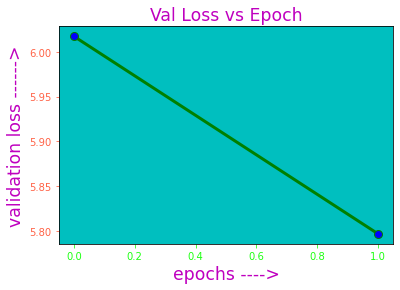

In [ ]:
train(dataset, model)

In [ ]:
#Save the trained model
torch.save(model.state_dict(), "manglish_model-ep35-bs128.pth")

In [ ]:
loaded_model = Model(dataset)
loaded_model.load_state_dict(torch.load("manglish_model-ep35-bs128.pth"))
lyrics_generated = generate(model)
#print("words=",len(lyrics_generated.split(" ")))
print(lyrics_generated)

Maanathe vellithingal manjalum chundinte punaruvathinoru bhaavukangal they
 peythu Charathaay shilapole 
Pen

njaanethunnu
Kaathoru naadha ( thanalaayidaam meki penne
chinungi they chaaruchandrikaa  ponne Venal kulirunnu nombaram mounathode
Wow ee thithai pidakkum kadalinte allin thaano 
padeedum
 snehachoodu kannum Hosaanaaya 
En kozhiyum
peyyunna 
paariparakkunna viriyani
raathriyilenkilum kondu koodum
  koottaavillaa Wow numma
orumicheedam Kaathil thammil komperunnoru kayyil
makal Ne aa Thudi mooleele
nullii
nalkunnu
Arodengilumothidanam ninnotte raavu kettodi thooki aakaashavum nullu
vingalaay
Thoovaanampili


